In [1]:
!java -version

java version "1.8.0_191"
Java(TM) SE Runtime Environment (build 1.8.0_191-b12)
Java HotSpot(TM) 64-Bit Server VM (build 25.191-b12, mixed mode)


In [1]:
from orbit.utils.dataset import load_iclaims

ModuleNotFoundError: No module named 'orbit'

In [ ]:
import pmdarima

#Important reading
https://stackoverflow.com/questions/67343172/why-is-pandas-udf-not-being-parallelized

In [4]:
from pyspark.sql import SparkSession
import pyspark
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels
mpl.rcParams['figure.figsize']=(10,8)
mpl.rcParams['axes.grid']= False
#pyarrow: enables pandas_udf. Spark to pandas in a non pickle-unpickle way

In [4]:
#spark = SparkSession.builder.master('local').getOrCreate() Runned thourgh yarn as master, commented once moving from local to CESGA's cluster
#There is no need for a programatically write

In [5]:
spark

In [5]:
#Dummy example from github
url='https://raw.githubusercontent.com/srivatsan88/YouTubeLI/master/dataset/weekly_sales_data.csv'
df=pd.read_csv(url)
df

,date,store_id,sales
0,1/6/2019,25,736657.2267
1,1/6/2019,26,233711.0000
2,1/6/2019,28,692156.3794
3,1/6/2019,29,213706.8000
4,1/6/2019,30,266455.0000
...,...,...,...
495,12/15/2019,31,401803.3590
496,12/15/2019,35,135799.1429
497,12/15/2019,38,115424.2250
498,12/15/2019,41,103375.0000


In [7]:
df.dtypes

date         object
store_id      int64
sales       float64
dtype: object

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      500 non-null    object 
 1   store_id  500 non-null    int64  
 2   sales     500 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 11.8+ KB


In [6]:
df.date = pd.to_datetime(df.date, infer_datetime_format=True)
df

,date,store_id,sales
0,2019-01-06,25,736657.2267
1,2019-01-06,26,233711.0000
2,2019-01-06,28,692156.3794
3,2019-01-06,29,213706.8000
4,2019-01-06,30,266455.0000
...,...,...,...
495,2019-12-15,31,401803.3590
496,2019-12-15,35,135799.1429
497,2019-12-15,38,115424.2250
498,2019-12-15,41,103375.0000


In [10]:
df.isnull().any()

date        False
store_id    False
sales       False
dtype: bool

In [11]:
df.nunique()

date         50
store_id     10
sales       500
dtype: int64

In [12]:
df.describe()

,store_id,sales
count,500.0000,5.000000e+02
mean,32.7000,4.470800e+05
std,6.1714,2.970660e+05
min,25.0000,1.278800e+04
25%,28.0000,2.526557e+05
50%,30.5000,3.150259e+05
75%,38.0000,6.845418e+05
max,44.0000,1.631585e+06


In [13]:
df.store_id.value_counts()

44    50
41    50
38    50
35    50
31    50
30    50
29    50
28    50
26    50
25    50
Name: store_id, dtype: int64

In [14]:
df_wrangling = df.copy()

In [7]:
df_wrangling = df_wrangling.set_index('date')

NameError: name 'df_wrangling' is not defined

In [16]:
df_wrangling

,store_id,sales
date,,
2019-01-06,25,736657.2267
2019-01-06,26,233711.0000
2019-01-06,28,692156.3794
2019-01-06,29,213706.8000
2019-01-06,30,266455.0000
...,...,...
2019-12-15,31,401803.3590
2019-12-15,35,135799.1429
2019-12-15,38,115424.2250


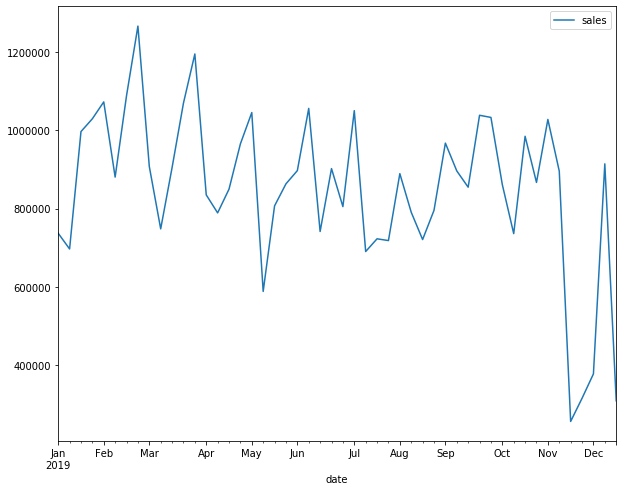

In [17]:
df_wrangling.query('store_id==25')[['sales']].plot()

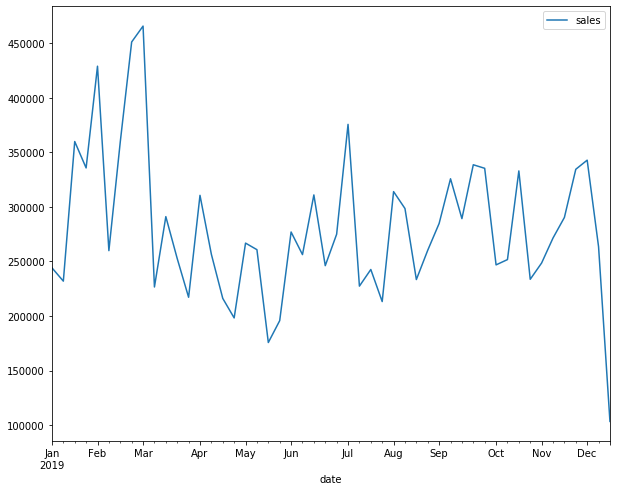

In [18]:
df_wrangling.query('store_id==41')[['sales']].plot()

In [8]:
#As we see, we find different behaviours for each subset (in this case of stores). Then, it should be correct to create multiple models,
#One at least per TS
s_df = spark.createDataFrame(df)
s_df.show(5)

+-------------------+--------+-----------+
|               date|store_id|      sales|
+-------------------+--------+-----------+
|2019-01-06 00:00:00|      25|736657.2267|
|2019-01-06 00:00:00|      26|   233711.0|
|2019-01-06 00:00:00|      28|692156.3794|
|2019-01-06 00:00:00|      29|   213706.8|
|2019-01-06 00:00:00|      30|   266455.0|
+-------------------+--------+-----------+
only showing top 5 rows



In [9]:
s_df.printSchema()

root
 |-- date: timestamp (nullable = true)
 |-- store_id: long (nullable = true)
 |-- sales: double (nullable = true)



In [21]:
s_df.count()

500

In [10]:
s_df.select(['store_id']).groupBy('store_id').agg({'store_id':'count'}) #lazy evaluation

DataFrame[store_id: bigint, count(store_id): bigint]

In [11]:
s_df.select(['store_id']).groupBy('store_id').agg({'store_id':'count'}).show()

+--------+---------------+
|store_id|count(store_id)|
+--------+---------------+
|      26|             50|
|      29|             50|
|      31|             50|
|      25|             50|
|      41|             50|
|      28|             50|
|      44|             50|
|      35|             50|
|      38|             50|
|      30|             50|
+--------+---------------+



Often we might want to store the spark Data frame as the table and query it, to convert Data frame into temporary view that is available for only that spark session, we use registerTempTable or createOrReplaceTempView (Spark > = 2.0) on our spark Dataframe.

createorReplaceTempView is used when you want to store the table for a particular spark session.

createOrReplaceTempView creates (or replaces if that view name already exists) a lazily evaluated "view" that you can then use like a hive table in Spark SQL. It does not persist to memory unless you cache the dataset that underpins the view.

In [4]:
s_df.createOrReplaceTempView('sales')

NameError: name 's_df' is not defined

In [12]:
spark.sql('''
    SELECT 
        store_id
        ,count(*)
    FROM Sales
    GROUP BY
        store_id
    ORDER BY
        store_id
''').show()#now spark sql works on our temporary view just stored for this session

AnalysisException: 'Table or view not found: Sales; line 5 pos 9'

In [7]:
new_query = '''
    SELECT
        store_id,
        date as ds,
        SUM(sales) as y
    FROM sales
    GROUP BY
        store_id,
        ds
    ORDER BY
        store_id,
        ds
'''
spark.sql(new_query).show()#sd and y renaming stands for prophet and sarimax from statsmodels prerequirements

+--------+----------+------------------+
|store_id|        ds|                 y|
+--------+----------+------------------+
|      25| 1/13/2019|       696457.1717|
|      25| 1/20/2019|        996876.875|
|      25| 1/27/2019|        1029737.05|
|      25|  1/6/2019|       736657.2267|
|      25|10/13/2019|        735723.327|
|      25|10/20/2019|         984872.55|
|      25|10/27/2019|       866777.1362|
|      25| 10/6/2019|          861162.1|
|      25|11/10/2019|         895675.95|
|      25|11/17/2019|       255034.3333|
|      25|11/24/2019|          314210.5|
|      25| 11/3/2019|1028016.8470000001|
|      25| 12/1/2019|       376708.0633|
|      25|12/15/2019|       307857.8817|
|      25| 12/8/2019|       914292.7833|
|      25| 2/10/2019|       880462.4681|
|      25| 2/17/2019|        1088756.78|
|      25| 2/24/2019|       1266928.313|
|      25|  2/3/2019|       1072873.705|
|      25| 3/10/2019|       747920.9824|
+--------+----------+------------------+
only showing top

De la manera actual, tendriamos las distintas store id en chuncks existiendo en los recursos de ram destinados a cada nodo. Esto es suboptimo, ya que cada store_id es una tienda, con sus ventas asignadas al primero de cada semana. Cada tienda tiene su propia estacionalidad, trend y demas. Luego cada una requiere su propio modelo. No tiene sentido usar pandas_udf para hacer forecasting de la tienda 25, y que la mitad de los datos esten en un nodo, la otra mitad en otro, pues al final todos estos datos pertenecen a la misma serie temporal. Lo ideal es que cada nodo contenga una tienda. Entonces, hacemos forecasting de cada tienda en cada nodo. Esto es asi porque este problema no es de prediccion de series temporales multivariante, sino prediccion de multiples series temporales monovariantes. Si nuestro problema esta mas orientado a que la ingesta de datos de una unica serie temporal es enorme, y no podemos agrupar para subir en granularidad, no quedaria mas remedio que aceptar que la prediccion se ejecutara entre nodos , perdiendo parte de las ventajas de la abstraccion que es map reduce. 
Inciso: pandas_udf es pandas user-defined functions. Solo funciona en python3

In [27]:
s_df.explain()

== Physical Plan ==
Scan ExistingRDD[date#0,store_id#1L,sales#2]


In [28]:
s_df.rdd.getNumPartitions()

2

In [8]:
store_part = (spark.sql(new_query).repartition(spark.sparkContext.defaultParallelism, ['store_id'])).cache()#guardarlo en cache

Cache explanation:
https://sparkbyexamples.com/spark/spark-dataframe-cache-and-persist-explained/

In [193]:
store_part.explain()

== Physical Plan ==
InMemoryTableScan [store_id#1L, ds#50, y#51]
   +- InMemoryRelation [store_id#1L, ds#50, y#51], StorageLevel(disk, memory, deserialized, 1 replicas)
         +- Exchange hashpartitioning(store_id#1L, 2)
            +- *(3) Sort [store_id#1L ASC NULLS FIRST, ds#50 ASC NULLS FIRST], true, 0
               +- Exchange rangepartitioning(store_id#1L ASC NULLS FIRST, ds#50 ASC NULLS FIRST, 200)
                  +- *(2) HashAggregate(keys=[store_id#1L, date#0], functions=[sum(sales#2)])
                     +- Exchange hashpartitioning(store_id#1L, date#0, 200)
                        +- *(1) HashAggregate(keys=[store_id#1L, date#0], functions=[partial_sum(sales#2)])
                           +- Scan ExistingRDD[date#0,store_id#1L,sales#2]


Cache() over a DataFrame (as it is the case on the cell above) is an alias for Persist (in memory and disk).  Do not mistake this with rdd.cache(), since for rdds, the default parameter of this persist alias is only only on disk.

In [10]:
store_part.rdd.getNumPartitions()

2

In [32]:
type(spark.sql(new_query).repartition(spark.sparkContext.defaultParallelism, ['store_id']))

pyspark.sql.dataframe.DataFrame

In [194]:
store_part

DataFrame[store_id: bigint, ds: string, y: double]

In [34]:
#Time to use pandas udf
#We first need to import all sql types from pyspark since we are using them for an schema
#We need to create an schema of the returned object from the udf function
#for example, in pandas_udf calling prophet, it will be ds, stored_id,y,yhat,yhat_upper and yhat_lower,
#For this example, we are using ARIMA family models

Sadly, pyspark doesnt have a functionality for visualizing, so before collecting in the master node, you might try to roll up on aggregation to prevent memory issues, then visualize the agregated data. However, if you only care about the autocorrelation as a value, you can always use a pandas udf that returns the acf of each time series. The only real spark native way of visualizing is using https://zeppelin.apache.org/docs/latest/quickstart/spark_with_zeppelin.html zeppelin notebooks, however this might be saved for a future enhancement since implies more tools integration

In [11]:
from pyspark.sql.types import *
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot


In [12]:
autocorrelation_plot(store_part)

TypeError: object of type 'DataFrame' has no len()

In [15]:
#First lets do it out of pandas_udf as a dummier example,lets use store_id 25 for the moment
df_25=df.copy()
df_25= df_25[df_25.store_id ==25]
df_25.head(5)

,date,store_id,sales
0,1/6/2019,25,7.366572e+05
10,1/13/2019,25,6.964572e+05
20,1/20/2019,25,9.968769e+05
30,1/27/2019,25,1.029737e+06
40,2/3/2019,25,1.072874e+06


In [16]:
#df_25.drop(columns=['store_id'])
df_25.head()
df_25.index=df_25.date
df_25=df_25.drop(columns=['date'])

In [17]:
df_25=df_25.drop(columns=['store_id'])

In [115]:
dumb=df.copy()
dumb

,date,store_id,sales
0,1/6/2019,25,736657.2267
1,1/6/2019,26,233711.0000
2,1/6/2019,28,692156.3794
3,1/6/2019,29,213706.8000
4,1/6/2019,30,266455.0000
...,...,...,...
495,12/15/2019,31,401803.3590
496,12/15/2019,35,135799.1429
497,12/15/2019,38,115424.2250
498,12/15/2019,41,103375.0000


In [111]:
dumb=dumb.set_index('date')
dumb

,store_id,sales
date,,
1/6/2019,25,736657.2267
1/6/2019,26,233711.0000
1/6/2019,28,692156.3794
1/6/2019,29,213706.8000
1/6/2019,30,266455.0000
...,...,...
12/15/2019,31,401803.3590
12/15/2019,35,135799.1429
12/15/2019,38,115424.2250


In [112]:
dumb.reset_index(level=0, inplace=True)

In [113]:
dumb


,date,store_id,sales
0,1/6/2019,25,736657.2267
1,1/6/2019,26,233711.0000
2,1/6/2019,28,692156.3794
3,1/6/2019,29,213706.8000
4,1/6/2019,30,266455.0000
...,...,...,...
495,12/15/2019,31,401803.3590
496,12/15/2019,35,135799.1429
497,12/15/2019,38,115424.2250
498,12/15/2019,41,103375.0000


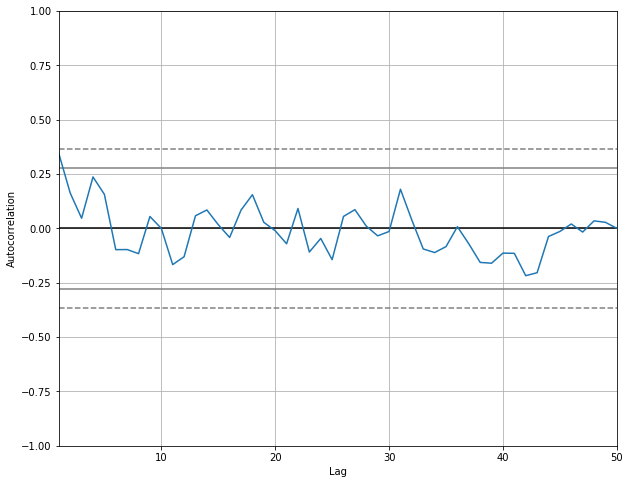

In [18]:
autocorrelation_plot(df_25)#any lag point overpasses gareal ussian noise. If the real TFM goal were predicting this,
#I will automatically switch to holts winters, prophet, gaussian forecasting (orbit) etc. Lets select 2 since seems to
#be the closer one as AR parameter (and you should look for seasonality, which seems to be more clear)

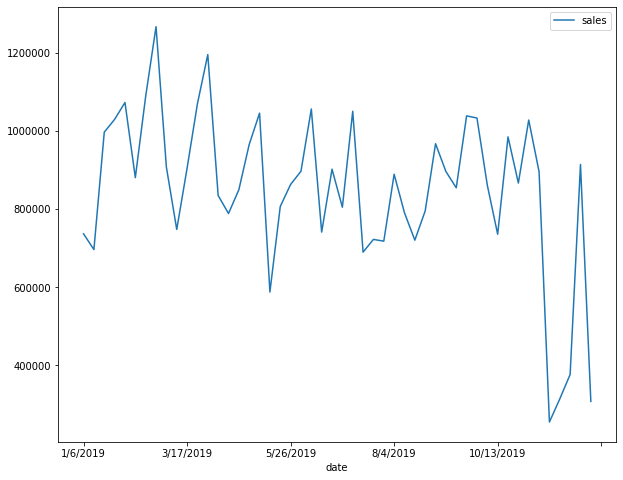

In [19]:
from matplotlib import pyplot
df_25.plot()
pyplot.show()

In [20]:
from statsmodels.tsa.stattools import adfuller
adfuller(df_25)#First element is the p-value of the augmented dickey fuller test, whose H0 null hypotesis is
#that the ts is not stationary. 0.84 is clearly non stationary, we need to differenciate

(-0.7094873999112801,
 0.8442767584981496,
 5,
 44,
 {'1%': -3.5885733964124715,
  '5%': -2.929885661157025,
  '10%': -2.6031845661157025},
 1037.9375947503395)

In [21]:
df_25_diff=df_25.diff().dropna()#Obviously, the first cvalue of the differenciation is a NaN
df_25_diff.tail()

,sales
date,
11/17/2019,-640641.6167
11/24/2019,59176.1667
12/1/2019,62497.5633
12/8/2019,537584.7200
12/15/2019,-606434.9016


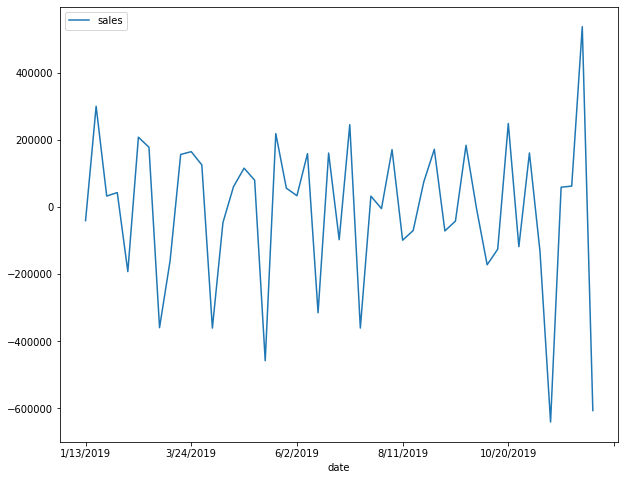

In [22]:
df_25_diff.plot()
pyplot.show()


In [23]:
adfuller(df_25_diff)#Now it is stationary, but we need tp either, forecast and give the substraction back. 
#Or being just lazy and use of the inbuilt methods where this is already considered in stats model. Howver
#Even for that making the manual check is useful in order to know that as soon as we differenciate once
#Were are having smaller than 0.05 p-values (actually 0.01) as dickey fuller test, then differenciating once is more than enough

(-3.248606176022395,
 0.01733801271363754,
 4,
 44,
 {'1%': -3.5885733964124715,
  '5%': -2.929885661157025,
  '10%': -2.6031845661157025},
 1009.5220194472221)

In [24]:
df_25_diff.index

Index(['1/13/2019', '1/20/2019', '1/27/2019', '2/3/2019', '2/10/2019',
       '2/17/2019', '2/24/2019', '3/3/2019', '3/10/2019', '3/17/2019',
       '3/24/2019', '3/31/2019', '4/7/2019', '4/14/2019', '4/21/2019',
       '4/28/2019', '5/5/2019', '5/12/2019', '5/19/2019', '5/26/2019',
       '6/2/2019', '6/9/2019', '6/16/2019', '6/23/2019', '6/30/2019',
       '7/7/2019', '7/14/2019', '7/21/2019', '7/28/2019', '8/4/2019',
       '8/11/2019', '8/18/2019', '8/25/2019', '9/1/2019', '9/8/2019',
       '9/15/2019', '9/22/2019', '9/29/2019', '10/6/2019', '10/13/2019',
       '10/20/2019', '10/27/2019', '11/3/2019', '11/10/2019', '11/17/2019',
       '11/24/2019', '12/1/2019', '12/8/2019', '12/15/2019'],
      dtype='object', name='date')

In [25]:
df_25.head(20)

,sales
date,
1/6/2019,7.366572e+05
1/13/2019,6.964572e+05
1/20/2019,9.968769e+05
1/27/2019,1.029737e+06
2/3/2019,1.072874e+06
2/10/2019,8.804625e+05
2/17/2019,1.088757e+06
2/24/2019,1.266928e+06
3/3/2019,9.075101e+05


/opt/cesga/anaconda/Anaconda3-2020.02/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)
/opt/cesga/anaconda/Anaconda3-2020.02/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)
/opt/cesga/anaconda/Anaconda3-2020.02/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)
/opt/cesga/anaconda/Anaconda3-2020.02/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/cesga/anaconda/Anaconda3-2020.02/lib/python3.7/si

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                   50
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -671.428
Date:                Thu, 23 Jun 2022   AIC                           1350.856
Time:                        09:56:26   BIC                           1358.423
Sample:                    01-06-2019   HQIC                          1353.727
                         - 12-15-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2052      0.191      1.073      0.283      -0.170       0.580
ar.L2         -0.0759      0.149     -0.510      0.610      -0.367       0.216
ma.L1         -0.6092      0.203     -3.006      0.0

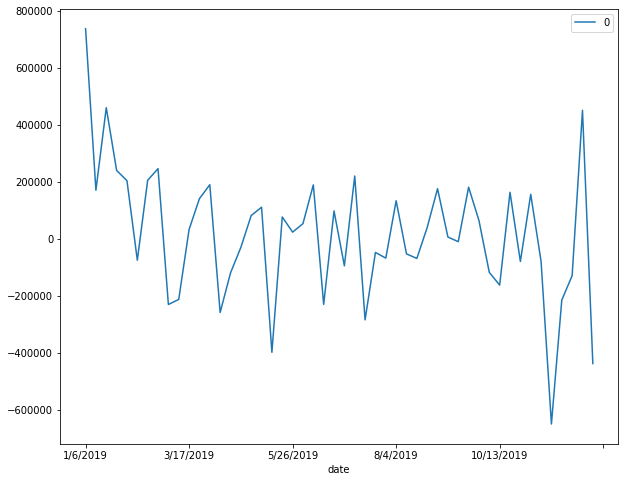

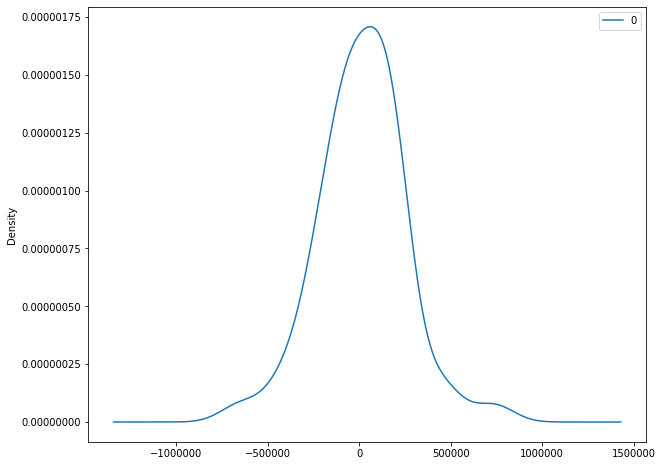

                   0
count      50.000000
mean    15811.071148
std    235717.247889
min   -649612.723917
25%   -112210.924729
50%     28003.350954
75%    168391.743522
max    736657.226700


In [26]:
# fit modfrom statsmodels.tsa.arima.model import ARIMAel
from pandas import DataFrame
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_25, order=(2,1,1))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

In [132]:
model_fit.forecast(10)


2019-12-22    409198.163141
2019-12-29    476026.887122
2020-01-05    482047.856698
2020-01-12    478210.543668
2020-01-19    476966.071889
2020-01-26    477001.984454
2020-02-02    477103.819303
2020-02-09    477121.990158
2020-02-16    477117.988801
2020-02-23    477115.788393
Freq: W-SUN, dtype: float64

In [28]:
#Later on, we will come back to time series forecasting with riggor, but as for now, we just have a dummy forecast to check pandas udf


In [29]:
X = df_25.values
size=int(len(X)*0.66)
train,test = X[0:size],X[size:len(X)]
history = [x for x in train]
prediction = []
for i in range(len(test)):
    model = ARIMA(history, order=(2,1,1))
    model_fit = model.fit()
    output=model_fit.forecast()
    yhat=output[0]
    prediction.append(yhat)
    obs = test[i]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
    
    

/opt/cesga/anaconda/Anaconda3-2020.02/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/cesga/anaconda/Anaconda3-2020.02/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


predicted=746747.932910, expected=795299.723300
predicted=786552.754862, expected=967413.106700
predicted=907646.619860, expected=896295.958300
predicted=882707.325729, expected=854582.422700
predicted=861785.025589, expected=1038662.264000
predicted=986049.541097, expected=1033151.636000
predicted=1003243.070232, expected=861162.100000
predicted=899668.578746, expected=735723.327000
predicted=801287.673637, expected=984872.550000
predicted=948303.283955, expected=866777.136200
predicted=871845.787581, expected=1028016.847000
predicted=980242.000733, expected=895675.950000
predicted=910599.111714, expected=255034.333300
predicted=536761.447799, expected=314210.500000
predicted=451694.469127, expected=376708.063300
predicted=417145.425383, expected=914292.783300
predicted=903356.748949, expected=307857.881700


In [13]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(test,prediction))
print(rmse)
pyplot.plot(test)
pyplot.plot(prediction, color='red')
pyplot.show()#Un modelo ciertamente malo, pero solo queremos aprender a meter el proceso general en pandas udf 
#con las particiones del cluster

NameError: name 'test' is not defined

In [31]:
prediction

[746747.932910176,
 786552.754861766,
 907646.6198595638,
 882707.3257291368,
 861785.0255889172,
 986049.5410973175,
 1003243.070232241,
 899668.5787455967,
 801287.6736367851,
 948303.2839550741,
 871845.7875813277,
 980242.0007331284,
 910599.1117141198,
 536761.4477991075,
 451694.4691269688,
 417145.42538259097,
 903356.748948617]

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                   50
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -671.428
Date:                Thu, 23 Jun 2022   AIC                           1350.856
Time:                        09:56:44   BIC                           1358.423
Sample:                    01-06-2019   HQIC                          1353.727
                         - 12-15-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2052      0.191      1.073      0.283      -0.170       0.580
ar.L2         -0.0759      0.149     -0.510      0.610      -0.367       0.216
ma.L1         -0.6092      0.203     -3.006      0.0

/opt/cesga/anaconda/Anaconda3-2020.02/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)
/opt/cesga/anaconda/Anaconda3-2020.02/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)
/opt/cesga/anaconda/Anaconda3-2020.02/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)
/opt/cesga/anaconda/Anaconda3-2020.02/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/cesga/anaconda/Anaconda3-2020.02/lib/python3.7/si

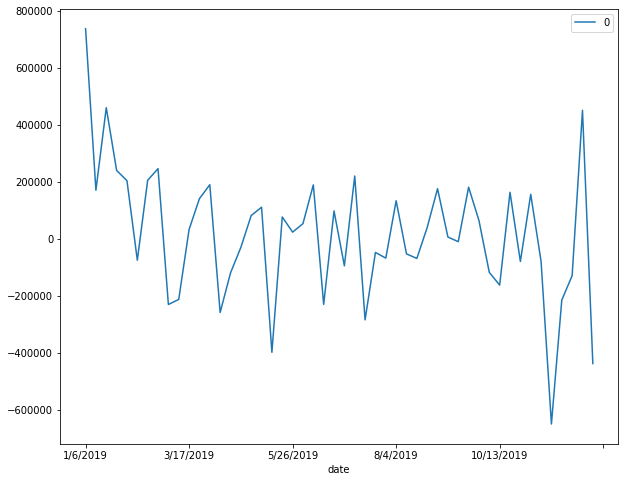

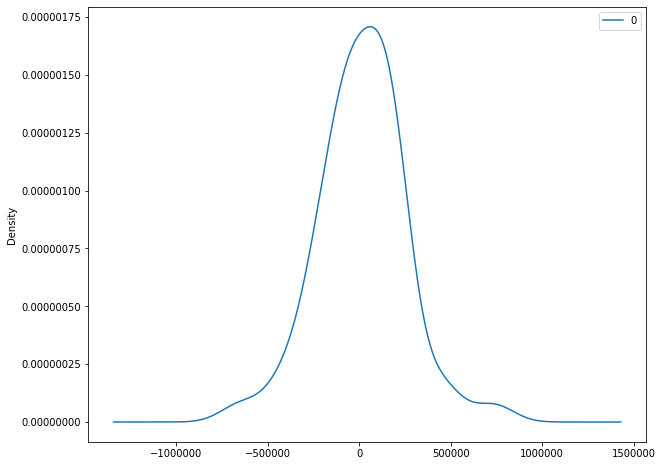

                   0
count      50.000000
mean    15811.071148
std    235717.247889
min   -649612.723917
25%   -112210.924729
50%     28003.350954
75%    168391.743522
max    736657.226700


In [32]:
#Now, going back to pandas_udf
# fit modfrom statsmodels.tsa.arima.model import ARIMAel
from pandas import DataFrame
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_25, order=(2,1,1))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

In [33]:
model.fit().forecast(10).dtypes #I expect a dataframe with a timestamp as an index

/opt/cesga/anaconda/Anaconda3-2020.02/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/cesga/anaconda/Anaconda3-2020.02/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


dtype('float64')

In [38]:
prediccion=model.fit().forecast(10)

In [35]:
store_part.show() #Lets now make a simple ts forecasting of the next 10 steps out of sample. for each stored id

+--------+----------+-----------+
|store_id|        ds|          y|
+--------+----------+-----------+
|      25| 1/13/2019|696457.1717|
|      25| 1/20/2019| 996876.875|
|      25| 1/27/2019| 1029737.05|
|      25|10/20/2019|  984872.55|
|      25|10/27/2019|866777.1362|
|      25| 10/6/2019|   861162.1|
|      25|12/15/2019|307857.8817|
|      25| 12/8/2019|914292.7833|
|      25|  2/3/2019|1072873.705|
|      25| 3/10/2019|747920.9824|
|      25| 3/31/2019|1195574.314|
|      25| 4/14/2019|788777.4167|
|      25| 5/12/2019| 587768.245|
|      25| 5/19/2019|806767.5946|
|      25| 5/26/2019|863148.7863|
|      25|  5/5/2019|1045632.688|
|      25| 6/16/2019|741174.1026|
|      25| 7/21/2019|722489.5417|
|      25| 7/28/2019|   717929.3|
|      25| 8/25/2019|795299.7233|
+--------+----------+-----------+
only showing top 20 rows



Inciso, dado que el forecast que se obtiene con modelstats es un dataframe con la fecha como indice, y dado que esta estructura no es la de un dataframe con spark, posiblemente toque hacer alguna manipulacion para que el formato de salida de la funcion tenga ambas columnas (fecha y valor como Double o float) pero no fecha como indice

# OJO
## When you create a typical pandas udf, spark works row by row, then it executes 
for each row, the function. We dont want this for sure, we want to vectorize a certain amount of rows based on store_id. Then, we will use GROUPED_MAP

# TRUCO: puedes convertir internamente el pandas_udf en un pandas dataframe normal (la input es un dataframe de spark, no de pandas) para hacer las operaciones, ya que esta vectorizado.
##COrreccion: tan pronto como pones el decorador de pandas_udf, el chunck de un spark dataframe que se vectorice para pasarlo como argumento, se recastea a pandas dataframe como paso previo a la ejecucion de la funcion

In [124]:
from pandas import to_datetime
dumb=df.copy()
dumb.date=to_datetime(dumb.date)
dumb.set_index('date')
dumb.dtypes

date        datetime64[ns]
store_id             int64
sales              float64
dtype: object

In [125]:
dumb=dumb.set_index('date')
dumb.dtypes

store_id      int64
sales       float64
dtype: object

In [138]:
dumb.reset_index(level=0, inplace=True)
dumb.dtypes

date        datetime64[ns]
store_id             int64
sales              float64
dtype: object

In [129]:
store_part.show(1)


+--------+---------+-----------+
|store_id|       ds|          y|
+--------+---------+-----------+
|      25|1/13/2019|696457.1717|
+--------+---------+-----------+
only showing top 1 row



In [140]:
dumb=dumb.set_index('date')
dumb[['sales']]

,sales
date,
2019-01-06,736657.2267
2019-01-06,233711.0000
2019-01-06,692156.3794
2019-01-06,213706.8000
2019-01-06,266455.0000
...,...
2019-12-15,401803.3590
2019-12-15,135799.1429
2019-12-15,115424.2250


In [159]:
dumb=df.copy()
dumb=dumb.set_index('date')
dumb[dumb.store_id == 25][['sales']]

,sales
date,
1/6/2019,7.366572e+05
1/13/2019,6.964572e+05
1/20/2019,9.968769e+05
1/27/2019,1.029737e+06
2/3/2019,1.072874e+06
2/10/2019,8.804625e+05
2/17/2019,1.088757e+06
2/24/2019,1.266928e+06
3/3/2019,9.075101e+05


In [161]:
from statsmodels.tsa.arima.model import ARIMA
dumb=df.copy()
dumb=dumb.set_index('date')
dumb=dumb[dumb.store_id == 25][['sales']]
model = ARIMA(dumb, order=(2,1,1)).fit()
data=pd.DataFrame(model.forecast(2), columns=['y'])
data.reset_index(level=0, inplace=True)
data

/opt/cesga/anaconda/Anaconda3-2020.02/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)
/opt/cesga/anaconda/Anaconda3-2020.02/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)
/opt/cesga/anaconda/Anaconda3-2020.02/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


,index,y
0,2019-12-22,409198.163141
1,2019-12-29,476026.887122


In [166]:
data=data.rename(columns={'index':'ds'})


,ds,y
0,2019-12-22,409198.163141
1,2019-12-29,476026.887122


In [172]:
data['a']=int(df.store_id.iloc[0])
data

,ds,y,a
0,2019-12-22,409198.163141,25
1,2019-12-29,476026.887122,25


In [171]:
data[['a','y','ds']]

,a,y,ds
0,25,409198.163141,2019-12-22
1,25,476026.887122,2019-12-29


In [173]:
from pyspark.sql.types import * 
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.functions import current_date
from pandas import to_datetime

result_schema = StructType([
    StructField('ds', TimestampType()),
    StructField('store_id', IntegerType()),
    StructField('y', DoubleType())    
])


@pandas_udf(result_schema, PandasUDFType.GROUPED_MAP)
def forecast_sales(store_pd):
    df=store_pd.copy()
    df=df.set_index('ds')
    model = ARIMA(df[['y']], order=(2,1,1)).fit()
    pred=pd.DataFrame(model.forecast(2), columns=['y'])
    pred.reset_index(level=0, inplace=True)
    pred=pred.rename(columns={'index':'ds'})
    pred['store_id']=int(store_pd.store_id.iloc[0])
    return pred[['store_id','ds','y']]
    
    
    
    #size=int(len(X)*0.66)
    #train,test = X[0:size],X[size:len(X)]
    #history = [x for x in train]
    #prediction = []
    #store_pd.ds = pd.to_datetime(store_pd.ds)
    
        
results=(store_part.groupBy('store_id').apply(forecast_sales))
results.cache()
results.show()  
    

Py4JJavaError: An error occurred while calling o1252.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: 
Aborting TaskSet 114.0 because task 0 (partition 0)
cannot run anywhere due to node and executor blacklist.
Most recent failure:
Lost task 0.1 in stage 114.0 (TID 1050, c14-12.bd.cluster.cesga.es, executor 2): java.lang.IllegalArgumentException
	at java.nio.ByteBuffer.allocate(ByteBuffer.java:334)
	at org.apache.arrow.vector.ipc.message.MessageSerializer.readMessage(MessageSerializer.java:543)
	at org.apache.arrow.vector.ipc.message.MessageChannelReader.readNext(MessageChannelReader.java:58)
	at org.apache.arrow.vector.ipc.ArrowStreamReader.readSchema(ArrowStreamReader.java:132)
	at org.apache.arrow.vector.ipc.ArrowReader.initialize(ArrowReader.java:181)
	at org.apache.arrow.vector.ipc.ArrowReader.ensureInitialized(ArrowReader.java:172)
	at org.apache.arrow.vector.ipc.ArrowReader.getVectorSchemaRoot(ArrowReader.java:65)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.read(ArrowPythonRunner.scala:162)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.read(ArrowPythonRunner.scala:122)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:406)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.sql.execution.columnar.CachedRDDBuilder$$anonfun$1$$anon$1.hasNext(InMemoryRelation.scala:131)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:221)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:299)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1165)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1156)
	at org.apache.spark.storage.BlockManager.doPut(BlockManager.scala:1091)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1156)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:882)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:335)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:286)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$11.apply(Executor.scala:407)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:413)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)


Blacklisting behavior can be configured via spark.blacklist.*.

	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1890)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1878)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1877)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1877)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:929)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:929)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:929)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2111)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2049)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:740)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2073)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2094)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2113)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:365)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:38)
	at org.apache.spark.sql.Dataset.org$apache$spark$sql$Dataset$$collectFromPlan(Dataset.scala:3383)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2544)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2544)
	at org.apache.spark.sql.Dataset$$anonfun$53.apply(Dataset.scala:3364)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:78)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:73)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3363)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2544)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2758)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:254)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:291)
	at sun.reflect.GeneratedMethodAccessor91.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)


In [186]:
from pyspark.sql.types import StringType, IntegerType
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.functions import current_date
from pandas import to_datetime

result_schema = StructType([
    StructField('ds', StringType()),
    StructField('store_id', IntegerType()),
    StructField('y', StringType())    
])


@pandas_udf(result_schema, PandasUDFType.GROUPED_MAP)
def forecast_sales(store_pd):
    return store_pd[['store_id','ds','y']]
    
    
    
    #size=int(len(X)*0.66)
    #train,test = X[0:size],X[size:len(X)]
    #history = [x for x in train]
    #prediction = []
    #store_pd.ds = pd.to_datetime(store_pd.ds)
    
        
results=(store_part.groupBy('store_id').apply(forecast_sales))
results.cache()
results.show()  
    

Py4JJavaError: An error occurred while calling o1752.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: 
Aborting TaskSet 142.0 because task 0 (partition 0)
cannot run anywhere due to node and executor blacklist.
Most recent failure:
Lost task 0.1 in stage 142.0 (TID 1064, c14-12.bd.cluster.cesga.es, executor 2): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/cloudera/parcels/CDH-6.1.1-1.cdh6.1.1.p0.875250/lib/spark/python/pyspark/worker.py", line 372, in main
    process()
  File "/opt/cloudera/parcels/CDH-6.1.1-1.cdh6.1.1.p0.875250/lib/spark/python/pyspark/worker.py", line 367, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/opt/cloudera/parcels/CDH-6.1.1-1.cdh6.1.1.p0.875250/lib/spark/python/pyspark/serializers.py", line 284, in dump_stream
    batch = _create_batch(series, self._timezone)
  File "/opt/cloudera/parcels/CDH-6.1.1-1.cdh6.1.1.p0.875250/lib/spark/python/pyspark/serializers.py", line 253, in _create_batch
    arrs = [create_array(s, t) for s, t in series]
  File "/opt/cloudera/parcels/CDH-6.1.1-1.cdh6.1.1.p0.875250/lib/spark/python/pyspark/serializers.py", line 253, in <listcomp>
    arrs = [create_array(s, t) for s, t in series]
  File "/opt/cloudera/parcels/CDH-6.1.1-1.cdh6.1.1.p0.875250/lib/spark/python/pyspark/serializers.py", line 251, in create_array
    return pa.Array.from_pandas(s, mask=mask, type=t)
  File "pyarrow/array.pxi", line 661, in pyarrow.lib.Array.from_pandas
  File "pyarrow/array.pxi", line 207, in pyarrow.lib.array
  File "pyarrow/array.pxi", line 78, in pyarrow.lib._ndarray_to_array
  File "pyarrow/error.pxi", line 88, in pyarrow.lib.check_status
pyarrow.lib.ArrowTypeError: Expected a string or bytes dtype, got float64

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:452)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.read(ArrowPythonRunner.scala:172)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.read(ArrowPythonRunner.scala:122)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:406)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.sql.execution.columnar.CachedRDDBuilder$$anonfun$1$$anon$1.hasNext(InMemoryRelation.scala:131)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:221)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:299)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1165)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1156)
	at org.apache.spark.storage.BlockManager.doPut(BlockManager.scala:1091)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1156)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:882)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:335)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:286)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$11.apply(Executor.scala:407)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:413)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)


Blacklisting behavior can be configured via spark.blacklist.*.

	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1890)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1878)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1877)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1877)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:929)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:929)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:929)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2111)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2049)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:740)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2073)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2094)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2113)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:365)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:38)
	at org.apache.spark.sql.Dataset.org$apache$spark$sql$Dataset$$collectFromPlan(Dataset.scala:3383)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2544)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2544)
	at org.apache.spark.sql.Dataset$$anonfun$53.apply(Dataset.scala:3364)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:78)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:73)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3363)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2544)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2758)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:254)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:291)
	at sun.reflect.GeneratedMethodAccessor91.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)


In [192]:
store_part.show(1002)

+--------+----------+------------------+
|store_id|        ds|                 y|
+--------+----------+------------------+
|      25| 1/13/2019|       696457.1717|
|      25| 1/20/2019|        996876.875|
|      25| 1/27/2019|        1029737.05|
|      25|10/20/2019|         984872.55|
|      25|10/27/2019|       866777.1362|
|      25| 10/6/2019|          861162.1|
|      25|12/15/2019|       307857.8817|
|      25| 12/8/2019|       914292.7833|
|      25|  2/3/2019|       1072873.705|
|      25| 3/10/2019|       747920.9824|
|      25| 3/31/2019|       1195574.314|
|      25| 4/14/2019|       788777.4167|
|      25| 5/12/2019|        587768.245|
|      25| 5/19/2019|       806767.5946|
|      25| 5/26/2019|       863148.7863|
|      25|  5/5/2019|       1045632.688|
|      25| 6/16/2019|       741174.1026|
|      25| 7/21/2019|       722489.5417|
|      25| 7/28/2019|          717929.3|
|      25| 8/25/2019|       795299.7233|
|      25|  8/4/2019|       889238.6712|
|      25| 9/29/

In [179]:
results=store_part.groupBy('store_id')
results.show()

AttributeError: 'GroupedData' object has no attribute 'show'

In [81]:
store_part.show(1)

+--------+---------+-----------+
|store_id|       ds|          y|
+--------+---------+-----------+
|      25|1/13/2019|696457.1717|
+--------+---------+-----------+
only showing top 1 row



In [76]:
from pyspark.sql.functions import current_date
results=(store_part.groupBy('store_id').apply(forecast_sales).withColumn('training_date', current_date()))

In [87]:
df.head()

,date,store_id,sales
0,1/6/2019,25,736657.2267
1,1/6/2019,26,233711.0000
2,1/6/2019,28,692156.3794
3,1/6/2019,29,213706.8000
4,1/6/2019,30,266455.0000


In [88]:
pd.to_datetime(df.date)

0     2019-01-06
1     2019-01-06
2     2019-01-06
3     2019-01-06
4     2019-01-06
         ...    
495   2019-12-15
496   2019-12-15
497   2019-12-15
498   2019-12-15
499   2019-12-15
Name: date, Length: 500, dtype: datetime64[ns]

In [71]:
store_part.show()

+--------+----------+-----------+
|store_id|        ds|          y|
+--------+----------+-----------+
|      25| 1/13/2019|696457.1717|
|      25| 1/20/2019| 996876.875|
|      25| 1/27/2019| 1029737.05|
|      25|10/20/2019|  984872.55|
|      25|10/27/2019|866777.1362|
|      25| 10/6/2019|   861162.1|
|      25|12/15/2019|307857.8817|
|      25| 12/8/2019|914292.7833|
|      25|  2/3/2019|1072873.705|
|      25| 3/10/2019|747920.9824|
|      25| 3/31/2019|1195574.314|
|      25| 4/14/2019|788777.4167|
|      25| 5/12/2019| 587768.245|
|      25| 5/19/2019|806767.5946|
|      25| 5/26/2019|863148.7863|
|      25|  5/5/2019|1045632.688|
|      25| 6/16/2019|741174.1026|
|      25| 7/21/2019|722489.5417|
|      25| 7/28/2019|   717929.3|
|      25| 8/25/2019|795299.7233|
+--------+----------+-----------+
only showing top 20 rows



In [69]:
dummy=df_25.copy()
dummy['new_column'] = 23
dummy

,sales,new_column
date,,
1/6/2019,7.366572e+05,23
1/13/2019,6.964572e+05,23
1/20/2019,9.968769e+05,23
1/27/2019,1.029737e+06,23
2/3/2019,1.072874e+06,23
2/10/2019,8.804625e+05,23
2/17/2019,1.088757e+06,23
2/24/2019,1.266928e+06,23
3/3/2019,9.075101e+05,23


In [53]:
from pyspark.sql.functions import current_date
current_date().show

Column<b'current_date()[show]'>